# Battery Energy Management System Using Reinforcement Learning 

## Abstract

 stochiastic nature of Renewable energy sources such solar energy may lead to imbalance supply and demand in micro-grid environment. Energy storage solutions and advances battery control and operation can address this imbalance. In this study,  dual deep Q-Network Reinforcement Learning (RL) framework is proposed for control and operation of a commercial building equipped with battery storage and photovoltaic (PV) system. In addition this study address the gap which currently exsits, where sophisticated optimal control strategies often applied to less accurate building models due to difficulties in applying such strategies in accuracte building simulation environment. In this paper a detailed Energy Plus (EP) building model inter-acts with Python using Functional Mockup Interface (FMI) which enables us to apply reinforcement learning based streategies to sophisticated building model in real time. The reinforcement learning agent learns the optimal energy management policicy using past expeiences. 

## Problem formulation

Morern building energy simulation tools such as EnergyPlus are optimized for building energy performance simulation but they only offer low level of support by controling set-points and componenets availability. Advanced control strategies require felxible I/O manipulation which is not currently available in Energy Plus. In this study co-simulation is used for coupling Energy Plus and external reinforcement learning control algorithms implemented in Python. In this setup, Python is used a the master and Energy Plus model is compiled using co-simulation to FMU which can be run in python. 

This study considers a small office building, PV system, inverters and a battery storage facility which is connected to the meain grid. The additional electricity can be bought from the grid if the PV production and the battery storage cannot meet the demand. The office building is 2 stody building where each floor ($3300  \, ft^2$) has 2 north and south facing thermmal zone. Each zone is served by a packaged single zone system consisting of an outside air economizer, DX coil, gas heating coil, and draw through supply air fan. There is night set up and setback. The fans are scheduled off at night.

System dynamics can be formalized as a partially obsevable Markov decision process where the reinforcement learning agent interacts with the environment. The Markovian process can be described with state space $\mathcal{S}$, action space $\mathcal{A}$ and reward $\mathcal{r}$ evaluated every 10 minutes over finite time horizon.

### State space

The space space is characterized using a tuple of six components ($s \in \mathcal{S}$) at each time step:

- Time Components: $s^d$ and $s^m$ corresponding to day of the week and moth of the year.

- PV production: $s^{PV}$ solar panel energy production.

- Battery state: $s^b$ energy level of the battery.

- Demand load: $s^l$ building load.

### Action space

The action space $a^{cd}$ is the charging and discharging energy of the battery discretized ($kWh$). (Future: use a modified actor ciritic algorithm to extend the reinforcement learning to continouse action space which is more realistic)

The battery dynamic at each time step is describe bellow:

\begin{align}
E_{t+1} = E_t + \eta_c a^{cd}, \quad a^{cd} > 0 \\
E_{t+1} = E_t + \frac{ a^{cd}}{\eta_c}, \quad a^{cd} < 0
\end{align}

Energy produced by the PV panenl is calculated as:

\begin{equation}
P = A_{panel} \, f_{active}  \, \eta_{cell} \, \eta_{inv} \, G_t
\end{equation}

where

\begin{align*}
P &:  \textrm{Electrical power produced by photovoltaics [W]} \\
G_t&: \textrm{Total solar radiation incident on PV array [W/m2]} \\
f_{active}&: \% \textrm{Active area of pv} \\
\eta_{cell}&: \textrm{PV efficiency} \\
\eta_{inv}&: \textrm{Inverter efficiency} \\
\end{align*}



### Reward function

The reward function is each time step is the negative of electiricty that should be bought or sold to the grid.

\begin{equation}
r = -(E_t^{demand} - E_t^{PV} - E_t^{battery})
\end{equation}

the objective of the reinforcement learning algorithm is to maximize the reward. In order to improve the stability of the agent, the reward function is clipped to $r \in [-1, 1]$.


### Deep reinforcement learning with double Q-learning network (DDQN)


For an agent following policy $\pi$ the value state-action pair $(s, a)$ and the state $s$ are defined as follows

\begin{align}
Q^{\pi} (s,a) = \mathbf{E} [R_t |s_t = s, a_t = a, \pi] \\ \nonumber
V^{\pi}(s) = \mathbf{E}_{a \sim \pi(s)} [Q^{\pi}(s,a)]
\end{align}


To solve the sequential Markov decision problem we need to learn the optimal value of each state as expected sum of the future reward when taking an action and following the optimal policy $\pi$.

\begin{equation}
Q_{\pi} (s, a) = \mathbf{E} [R_1 + \sum_{i=2} \gamma R_i | S_0 = s, A_0 = a, \pi] \\
\end{equation}


where $\gamma \in [0,1]$  is the discounted factor of future rewards which increases the importance of immediate rewards. The optimal policy is derived by choosing the highest valued action at each state which is $Q_* (s,a) = \max_{\pi} Q_{\pi} (s,a)$. Another important quantity is the advantage function relating the value of each state $V^{\pi}$ to the $Q$ function:

\begin{equation}
A^{\pi} (s,a) = Q^{\pi} (s,a) - V^{\pi}(s)
\end{equation}

where the difference between value function $V$ and the $Q$ function is a relative measure of the importance of taking each action.


The double deep Q-network is two multilayered neural network for a given state $s$ outputs the value of action values $Q(s,\dot,  \theta)$ where $\theta$ are the parameters of the network to be learned. Two properties of DDQN is the use of experience replay and separate target network, where both ingredients are proposed to improve the stability of predictions and reduce the over estimation of the certain actions which reduces the ability of the agent to learn new strategies. The experience replay is implemented by storing observed states and uniformly sample them for the memory to update the network. The target network with parameters $\theta^-$, is the same as the online network except it is updated every $\tau$ so that $\theta^-_t = \theta_t$. The target network output is defined as:

\begin{align}
y_i^{Double DQN} = r + \lambda Q(s^`, arg max_{a^`} Q(s^`, a^`; \theta_i) ; \theta^`
)
\end{align}



In [1]:
import numpy as np
from ddqn.environment import EP
from ddqn.DDQN import DDQNAgent
import os
import gc
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 10)

# Some utilities functions

def pplot(ax,y, colors=['b']):
    x = range(len(y))
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        for color in colors:
            ax.plot(x, y, color)
    fig.canvas.draw()


def check_path(path):
    if path != os.getcwd():
        os.chdir(path)


state_size = 6
action_size = 5
action_space = np.linspace(-10000, 10000, action_size)

env = EP('./EPlus/small_office.fmu', state_size=state_size,
         battery_capacity=30000, action_space=action_space, solar_panel_area=25)

agent = DDQNAgent(state_size, action_size, memory_lenght=10000,
                  discount=0.99, epsilon=1)
done = False
batch_size = 20
load_weights = 0
episodes = 50
times = 1
reward_list = []
r_list = np.array([])
total_reward = 0

if 'save' not in os.listdir('.'):
    os.mkdir('./save/')

if load_weights:
    agent.load('./save/ddqn.h5')


for e in range(episodes):
    states = env.reset()
    states = np.reshape(states, [states.shape[0], state_size])

    for time in range(times):
        actions = agent.act(states)
        next_state, reward, done = env.step(actions)
        next_state = np.reshape(next_state, [next_state.shape[0], state_size])
        agent.remember(states, actions, reward, next_state, done)
        states = next_state
        total_reward += reward.sum()
        reward_list.append(total_reward)
        r_list = np.append(r_list, reward)

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
    if e % 5 == 0:
        agent.update_target_network()
        agent.save("./save/ddqn.h5")
        print("episode: {}/{}, score: {}, e: {}"
              .format(e, episodes,time, agent.epsilon))


Using TensorFlow backend.


Simulation interval    : 0 - 86400.0 seconds.
Elapsed simulation time: 0.0460619926453 seconds.


ddqn/environment.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.state['weekday'] = self.date.weekday()
ddqn/environment.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.state['month'] = self.date.month


Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0403 - mean_squared_error: 0.0403
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1249 - mean_squared_error: 0.1249
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1174 - mean_squared_error: 0.1174
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2451 - mean_squared_error: 0.2451
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2727 - mean_squared_error: 0.2727
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4071 - mean_squared_error: 0.4071
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1328 - mean_squared_error: 0.1328
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0944 - mean_squared_error: 0.0944
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2907 - mean_squared_error: 0.2907
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1963 - mean_squared_error: 0.1963
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 0s - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0326 - mean_squared_error: 0.0326
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.2574 - mean_squared_error: 1.2574
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3051 - mean_squared_error: 0.3051
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3305 - mean_squared_error: 0.3305
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0452 - mean_squared_error: 0.0452
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1731 - mean_squared_error: 0.1731
Epoch 1/1
1/1 [==============================] - 0s - loss: 8.0302e-04 - mean_squared_error: 8.0302e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1223 - mean_squared_error: 0.1223
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0750 - mean_squared_error: 0.0750
Epoch 1/1
1/1 [===========================

1/1 [==============================] - 0s - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0877 - mean_squared_error: 0.0877
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3778 - mean_squared_error: 0.3778
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4829 - mean_squared_error: 0.4829
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0365 - mean_squared_error: 0.0365
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0278 - mean_squared_error: 0.0278
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.1825 - mean_squared_error: 0.1825
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0323 - mean_squared_error: 0.0323
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4719 - mean_squared_error: 0.4719
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2750 - mean_squared_error: 0.2750
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0246 - mean_squared_error: 0.0246
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2351 - mean_squared_error: 0.2351
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4656 - mean_squared_error: 0.4656
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2751 - mean_squared_error: 0.2751
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.1285 - mean_squared_error: 0.1285
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2268 - mean_squared_error: 0.2268
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2472 - mean_squared_error: 0.2472
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1328 - mean_squared_error: 0.1328
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1989 - mean_squared_error: 0.1989
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2848 - mean_squared_error: 0.2848
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0717 - mean_squared_error: 0.0717
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0681 - mean_squared_error: 0.0681
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0711 - mean_squared_error: 0.0711
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1512 - mean_squared_error: 0.1512
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0158 - mean_squared_error: 0.0158
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4919 - mean_squared_error: 0.4919
Epoch 1/1
1/1 [==============================] - 0s - loss: 8.1728e-04 - mean_squared_error: 8.1728e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0278 - mean_squared_error: 0.0278
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0354 - mean_squared_error: 0.0354
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0637 - mean_squared_error: 0.0637
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.7245e-04 - mean_squared_error: 1.7245e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0679 - mean_squared_error: 0.0679
Epoch 1/1
1/1 [===================

1/1 [==============================] - 0s - loss: 0.0370 - mean_squared_error: 0.0370
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1331 - mean_squared_error: 0.1331
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7969 - mean_squared_error: 0.7969
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.2377 - mean_squared_error: 1.2377
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1137 - mean_squared_error: 0.1137
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0788 - mean_squared_error: 0.0788
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1241 - mean_squared_error: 0.1241
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1162 - mean_squared_error: 0.1162
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.6859 - mean_squared_error: 0.6859
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 6.7469e-04 - mean_squared_error: 6.7469e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2576 - mean_squared_error: 0.2576
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2491 - mean_squared_error: 0.2491
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2126 - mean_squared_error: 0.2126
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1962 - mean_squared_error: 0.1962
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1703 - mean_squared_error: 0.1703
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0387 - mean_squared_error: 0.0387
Epoch 1/1
1/1 [===========================

1/1 [==============================] - 0s - loss: 0.1023 - mean_squared_error: 0.1023
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1295 - mean_squared_error: 0.1295
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0331 - mean_squared_error: 0.0331
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.8929 - mean_squared_error: 0.8929
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0890 - mean_squared_error: 0.0890
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0266 - mean_squared_error: 0.0266
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.4078 - mean_squared_error: 1.4078
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0240 - mean_squared_error: 0.0240
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0709 - mean_squared_error: 0.0709
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0778 - mean_squared_error: 0.0778
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1265 - mean_squared_error: 0.1265
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0719 - mean_squared_error: 0.0719
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.8645 - mean_squared_error: 2.8645
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2049 - mean_squared_error: 0.2049
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2034 - mean_squared_error: 0.2034
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2370 - mean_squared_error: 0.2370
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.6734 - mean_squared_error: 1.6734
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.1502 - mean_squared_error: 0.1502
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0267 - mean_squared_error: 0.0267
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1415 - mean_squared_error: 0.1415
Epoch 1/1
1/1 [==============================] - 0s - loss: 6.9898 - mean_squared_error: 6.9898
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0316 - mean_squared_error: 0.0316
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4877 - mean_squared_error: 0.4877
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4837 - mean_squared_error: 0.4837
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4734 - mean_squared_error: 0.4734
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1005 - mean_squared_error: 0.1005
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4484 - mean_squared_error: 0.4484
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.2756 - mean_squared_error: 0.2756
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2747 - mean_squared_error: 0.2747
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2714 - mean_squared_error: 0.2714
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1181 - mean_squared_error: 0.1181
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2604 - mean_squared_error: 0.2604
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0732 - mean_squared_error: 0.0732
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.9138 - mean_squared_error: 2.9138
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.3043 - mean_squared_error: 0.3043
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0230 - mean_squared_error: 0.0230
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1267 - mean_squared_error: 0.1267
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0216 - mean_squared_error: 0.0216
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1307 - mean_squared_error: 0.1307
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.3021 - mean_squared_error: 2.3021
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0639 - mean_squared_error: 0.0639
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1185 - mean_squared_error: 0.1185
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1141 - mean_squared_error: 0.1141
Epoch 1/1
1/1 [==============================] - 0

Running the simulation for 50 days. Resutls shows that the agent behavior is almost random. The middle figure show the commulative reward during the simulation period. Since the agent is acting randomly, 
the reward revieved from the environment is negative and decreasing. After day 40, the magnitude of reward slope which show better performance.

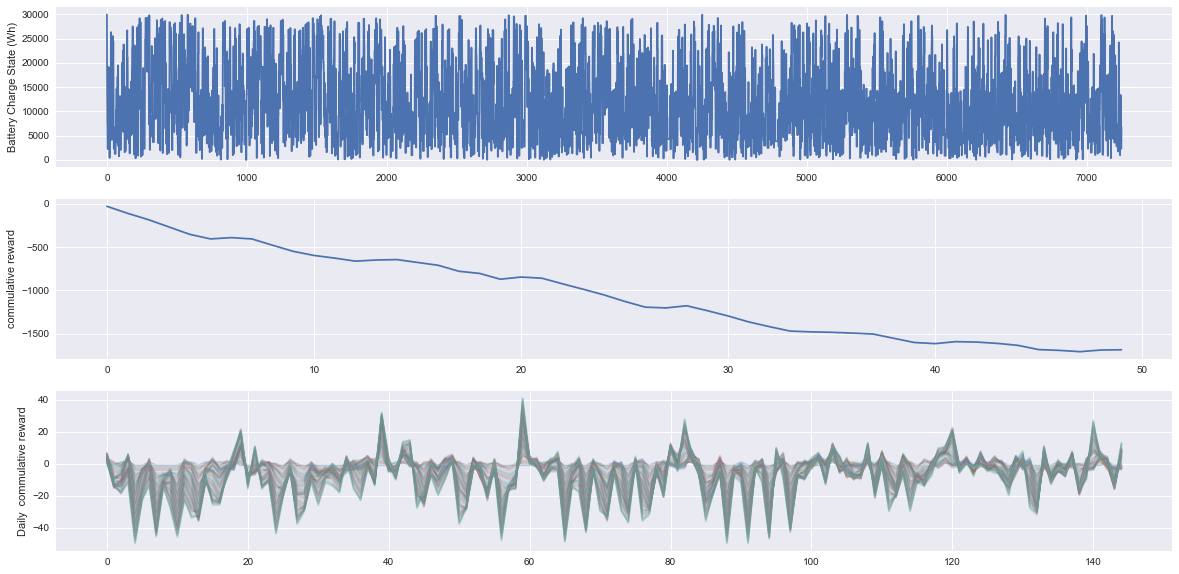

In [2]:
plt.subplot(311)
plt.plot(env.battery.state)
plt.ylabel('Battery Charge State (Wh)')

plt.subplot(312)
plt.plot(reward_list)
plt.ylabel('commulative reward')


plt.subplot(313)
a=plt.plot(np.cumsum(r_list.reshape(145, r_list.shape[0]/ 145), axis=1), alpha =0.3)
plt.ylabel('Daily  commulative reward')

The Figures bellow show the target and Q-network action value function value function whisch randomly oscillate  about zero which indicates random behavior.

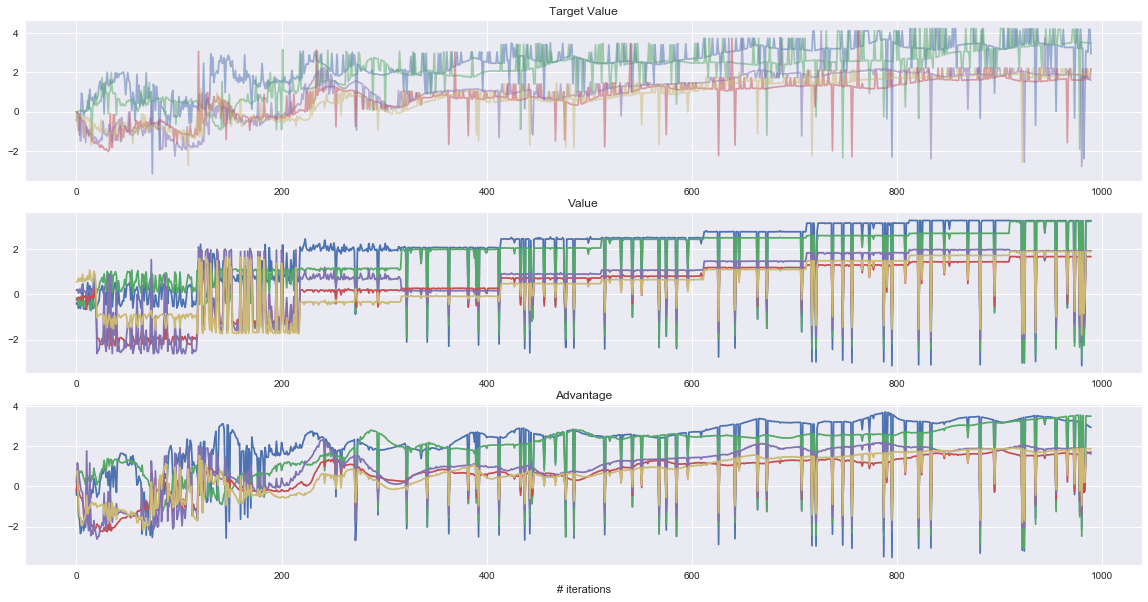

In [3]:
plt.subplot(311)
plt.plot(agent.target, alpha=.5)
plt.title('Target Value')
# plt.ylim((35,45))

plt.subplot(312)
plt.plot(agent.value)
plt.title('Value')
# plt.ylim((35,45))


plt.subplot(313)
plt.plot(agent.advantage)
plt.title('Advantage')
plt.xlabel('# iterations')



# Example: 24 hour ($01/01/2017$)

The building demand peaks around $4:30 pm$ which is about ($17 kW$). There is some PV generation in the afternoon  which slightly reduces the amount of electricity that is required to be bought.
The random behavior of the battery is not helping. The agent decides to charge the battery around $10:00 AM$ when there is no PV generation and building deand is near peak.

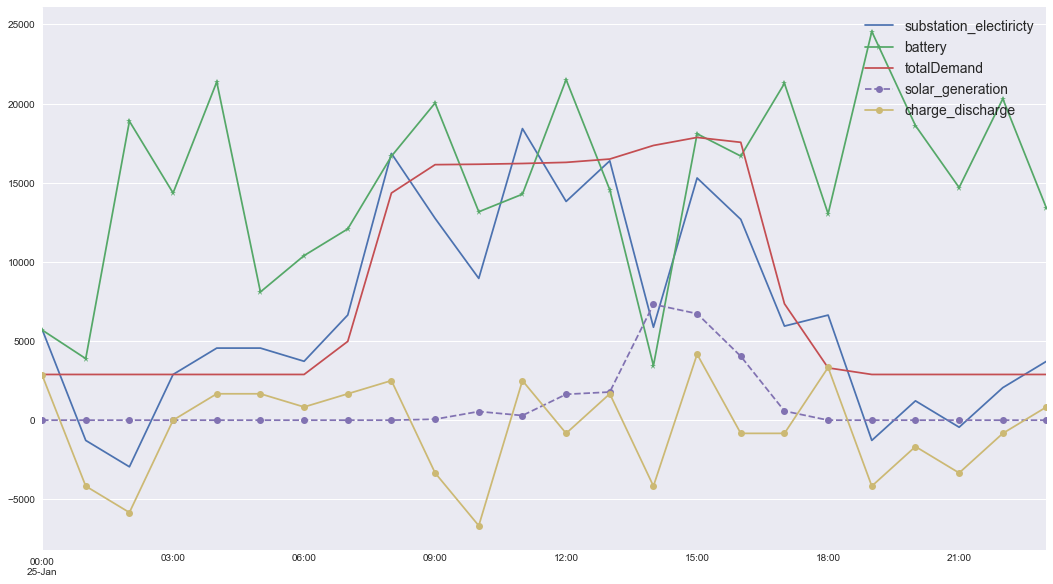

In [4]:
date = '2017-01-25'
env.store.substation_electiricty.resample('1H').mean()[date].plot(figsize=(18, 10))
env.store.battery.resample('1H').mean()[date].plot(style='-*')
env.store.totalDemand.resample('1H').mean()[date].plot(style='-')
env.store.solar_generation.resample('1H').mean()[date].plot(style='--o')
env.store.charge_discharge.resample('1H').mean()[date].plot(style='-o')
plt.legend(loc=1, fontsize=14)

In [1]:
import numpy as np
from ddqn.environment import EP
from ddqn.DDQN import DDQNAgent
import os
import gc
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

plt.rcParams["figure.figsize"] = (20, 10)

# Some utilities functions

def pplot(ax,y, colors=['b']):
    x = range(len(y))
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        for color in colors:
            ax.plot(x, y, color)
    fig.canvas.draw()


def check_path(path):
    if path != os.getcwd():
        os.chdir(path)


state_size = 6
action_size = 5
action_space = np.linspace(-10000, 10000, action_size)

env = EP('./EPlus/small_office.fmu', state_size=state_size,
         battery_capacity=30000, action_space=action_space, solar_panel_area=27)

agent = DDQNAgent(state_size, action_size, memory_lenght=10000,
                  discount=0.99, epsilon=1)
done = False
batch_size = 20
load_weights = 1
episodes = 50
times = 1
reward_list = []
r_list = np.array([])
total_reward = 0

if 'save' not in os.listdir('.'):
    os.mkdir('./save/')

if load_weights:
    agent.load('./save/ddqn.h5')


for e in range(episodes):
    states = env.reset()
    states = np.reshape(states, [states.shape[0], state_size])

    for time in range(times):
        actions = agent.act(states)
        next_state, reward, done = env.step(actions)
        next_state = np.reshape(next_state, [next_state.shape[0], state_size])
        agent.remember(states, actions, reward, next_state, done)
        states = next_state
        total_reward += reward.sum()
        reward_list.append(total_reward)
        r_list = np.append(r_list, reward)

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)
    if e % 4 == 0:
        agent.update_target_network()
        agent.save("./save/ddqn.h5")
        print("episode: {}/{}, score: {}, e: {}"
              .format(e, episodes,time, agent.epsilon))


Using TensorFlow backend.


Simulation interval    : 0 - 86400.0 seconds.
Elapsed simulation time: 0.0820791721344 seconds.


ddqn/environment.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.state['weekday'] = self.date.weekday()
ddqn/environment.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.state['month'] = self.date.month


Epoch 1/1
1/1 [==============================] - 0s - loss: 3.8750 - mean_squared_error: 3.8750
Epoch 1/1
1/1 [==============================] - 0s - loss: 5.1184 - mean_squared_error: 5.1184
Epoch 1/1
1/1 [==============================] - 0s - loss: 3.8223 - mean_squared_error: 3.8223
Epoch 1/1
1/1 [==============================] - 0s - loss: 4.0067 - mean_squared_error: 4.0067
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.8866 - mean_squared_error: 2.8866
Epoch 1/1
1/1 [==============================] - 0s - loss: 4.2484 - mean_squared_error: 4.2484
Epoch 1/1
1/1 [==============================] - 0s - loss: 4.3197 - mean_squared_error: 4.3197
Epoch 1/1
1/1 [==============================] - 0s - loss: 3.7298 - mean_squared_error: 3.7298
Epoch 1/1
1/1 [==============================] - 0s - loss: 4.5382 - mean_squared_error: 4.5382
Epoch 1/1
1/1 [==============================] - 0s - loss: 5.6498 - mean_squared_error: 5.6498
Epoch 1/1
1/1 [=========================

1/1 [==============================] - 0s - loss: 1.4664 - mean_squared_error: 1.4664
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1363 - mean_squared_error: 0.1363
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1002 - mean_squared_error: 0.1002
Epoch 1/1
1/1 [==============================] - 0s - loss: 2.0178 - mean_squared_error: 2.0178
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0579 - mean_squared_error: 0.0579
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0758 - mean_squared_error: 0.0758
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1178 - mean_squared_error: 0.1178
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0469 - mean_squared_error: 0.0469
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.2061 - mean_squared_error: 1.2061
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.5171 - mean_squared_error: 0.5171
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1408 - mean_squared_error: 0.1408
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.4789 - mean_squared_error: 0.4789
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0780 - mean_squared_error: 0.0780
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3554 - mean_squared_error: 0.3554
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0771 - mean_squared_error: 0.0771
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1227 - mean_squared_error: 0.1227
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0926 - mean_squared_error: 0.0926
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1235 - mean_squared_error: 0.1235
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1249 - mean_squared_error: 0.1249
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.1509 - mean_squared_error: 0.1509
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1448 - mean_squared_error: 0.1448
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0296 - mean_squared_error: 0.0296
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0588 - mean_squared_error: 0.0588
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3553 - mean_squared_error: 0.3553
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1843 - mean_squared_error: 0.1843
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1499 - mean_squared_error: 0.1499
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0349 - mean_squared_error: 0.0349
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1528 - mean_squared_error: 0.1528
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1031 - mean_squared_error: 0.1031
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0132 - mean_squared_error: 0.0132
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0458 - mean_squared_error: 0.0458
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0657 - mean_squared_error: 0.0657
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2146 - mean_squared_error: 0.2146
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0385 - mean_squared_error: 0.0385
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1973 - mean_squared_error: 0.1973
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 1/1
1/1 [==============================] - 0

Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0864 - mean_squared_error: 0.0864
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0859 - mean_squared_error: 0.0859
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3415 - mean_squared_error: 0.3415
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0832 - mean_squared_error: 0.0832
Epoch 1/1
1/1 [==============================] - 0s - loss: 16.5651 - mean_squared_error: 16.5651
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 1/1
1/1 [==============================] - 0s - loss: 15.2555 - mean_squared_error: 15.2555
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5021 - mean_squared_error: 0.5021
Epoch 1/1
1/1 [=====================

1/1 [==============================] - 0s - loss: 0.1085 - mean_squared_error: 0.1085
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0677 - mean_squared_error: 0.0677
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0939 - mean_squared_error: 0.0939
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7703 - mean_squared_error: 0.7703
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0379 - mean_squared_error: 0.0379
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0274 - mean_squared_error: 0.0274
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 1/1
1/1 [==============================] - 0s - loss: 4.5427e-04 - mean_squared_error: 4.5427e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3107 - mean_squared_error: 0.3107
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0039 - mean_squared_error: 0.0039
Epoch 1/1
1/1 [==============================] - 0s - loss: 6.3802e-04 - mean_squared_error: 6.3802e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0458 - mean_squared_error: 0.0458
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0450 - mean_squared_error: 0.0450
Epoch 1/1
1/1 [==============================] - 0s - loss: 7.0532e-04 - mean_squared_error: 7.0532e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 7.8994e-04 - mean_squared_error: 7.8994e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1099 - mean_squared_error: 0.1099
Epoch 1/1
1/1 [===

1/1 [==============================] - 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1153 - mean_squared_error: 0.1153
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0015 - mean_squared_error: 0.0015
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5517 - mean_squared_error: 0.5517
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2967 - mean_squared_error: 0.2967
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0093 - mean_squared_error: 0.0093
Epoch 1/1
1/1 [==============================] - 0s - loss: 7.8906e-04 - mean_squared_error: 7.8906e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0027 - mean_squared_error: 0.0027
Epoch 1/1
1/1 [===========================

1/1 [==============================] - 0s - loss: 0.1447 - mean_squared_error: 0.1447
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.1427 - mean_squared_error: 1.1427
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2100 - mean_squared_error: 0.2100
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1904 - mean_squared_error: 0.1904
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2379 - mean_squared_error: 0.2379
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.7631 - mean_squared_error: 0.7631
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3920 - mean_squared_error: 0.3920
Epoch 1/1
1/1 [==============================] - 0s - loss: 3.0300e-04 - mean_squared_error: 3.0300e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0051 - mean_squared_error: 0.0051
Epoch 1/1
1/1 [===========================

1/1 [==============================] - 0s - loss: 0.4714 - mean_squared_error: 0.4714
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0443 - mean_squared_error: 0.0443
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.5414 - mean_squared_error: 0.5414
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0283 - mean_squared_error: 0.0283
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0425 - mean_squared_error: 0.0425
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0186 - mean_squared_error: 0.0186
Epoch 1/1
1/1 [==============================] - 0

1/1 [==============================] - 0s - loss: 3.2905e-04 - mean_squared_error: 3.2905e-04
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0321 - mean_squared_error: 0.0321
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0306 - mean_squared_error: 0.0306
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.2295 - mean_squared_error: 0.2295
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.1730 - mean_squared_error: 0.1730
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0098 - mean_squared_error: 0.0098
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 1/1
1/1 [===========================

1/1 [==============================] - 0s - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0358 - mean_squared_error: 0.0358
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0355 - mean_squared_error: 0.0355
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0766 - mean_squared_error: 0.0766
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3864 - mean_squared_error: 0.3864
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 1/1
1/1 [==============================] - 0s - loss: 0.3852 - mean_squared_error: 0.3852
Epoch 1/1
1/1 [==============================] - 0s - loss: 1.7109e-04 - mean_squared_error: 1.7109e-04
Epoch 1/1
1/1 [===========================

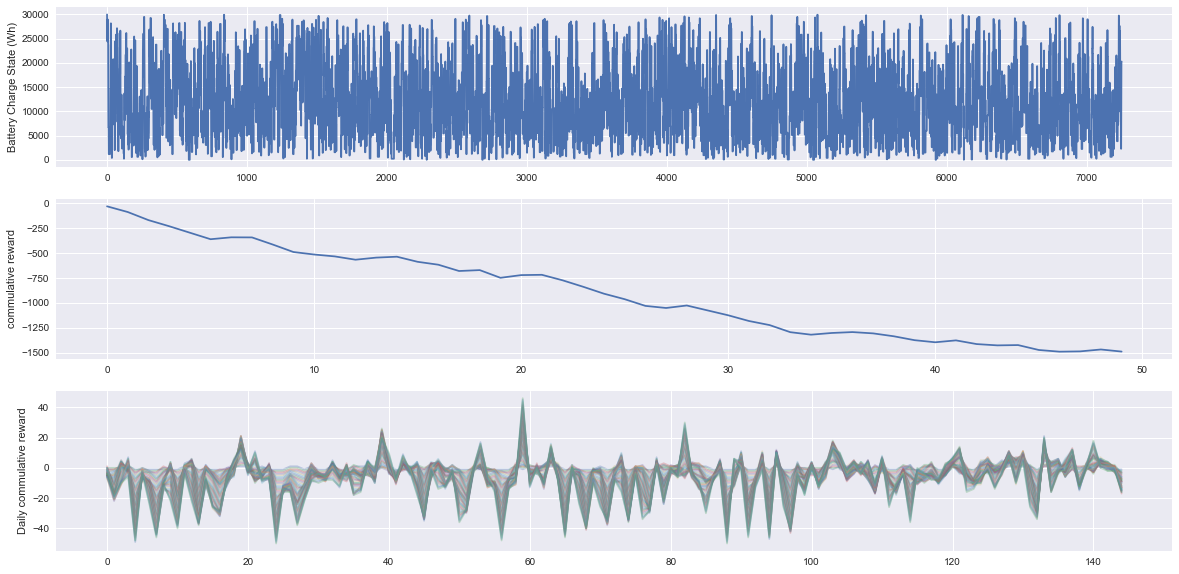

In [3]:
plt.subplot(311)
plt.plot(env.battery.state)
plt.ylabel('Battery Charge State (Wh)')

plt.subplot(312)
plt.plot(reward_list)
plt.ylabel('commulative reward')


plt.subplot(313)
a=plt.plot(np.cumsum(r_list.reshape(145, r_list.shape[0]/ 145), axis=1), alpha =0.3)
plt.ylabel('Daily commulative reward')

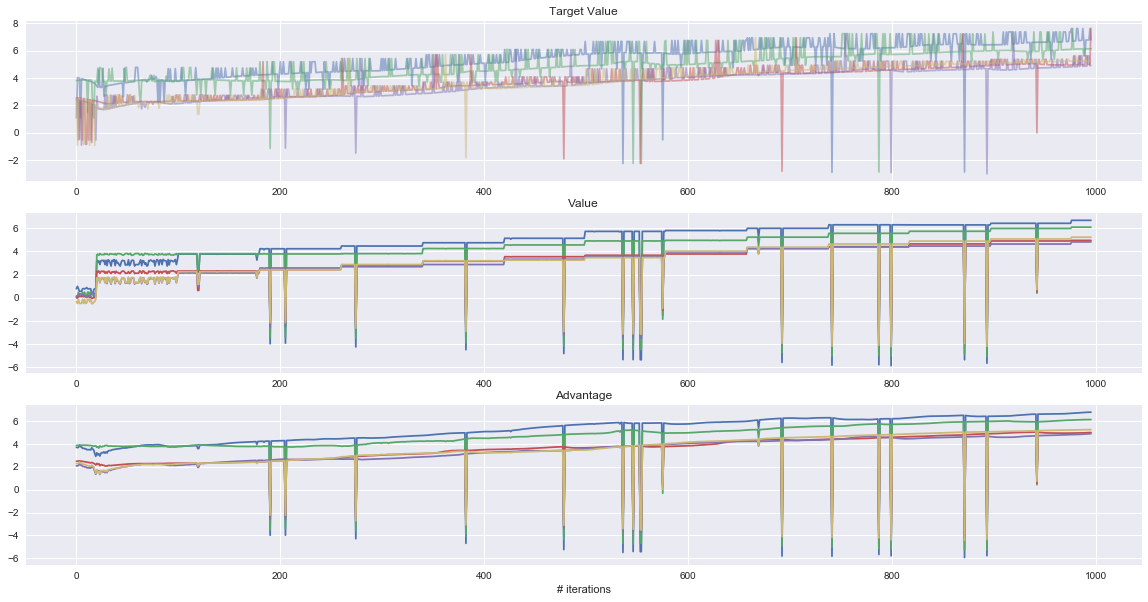

In [3]:
plt.subplot(311)
plt.plot(agent.target, alpha=.5)
plt.title('Target Value')
# plt.ylim((35,45))

plt.subplot(312)
plt.plot(agent.value)
plt.title('Value')
# plt.ylim((35,45))


plt.subplot(313)
plt.plot(agent.advantage)
plt.title('Advantage')
plt.xlabel('# iterations')

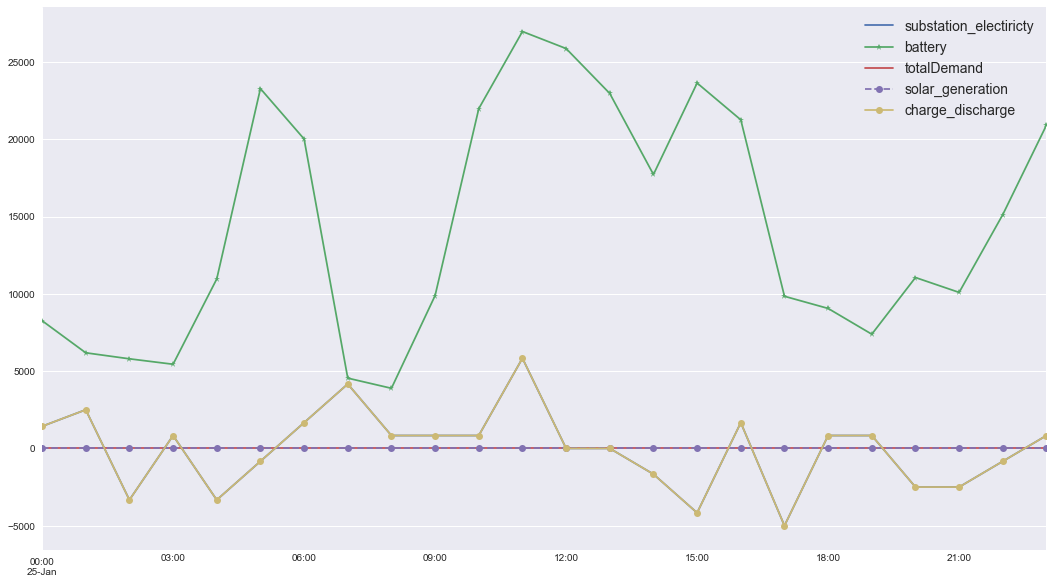

In [6]:
date = '2017-01-25'
env.store.substation_electiricty.resample('1H').mean()[date].plot(figsize=(18, 10))
env.store.battery.resample('1H').mean()[date].plot(style='-*')
env.store.totalDemand.resample('1H').mean()[date].plot(style='-')
env.store.solar_generation.resample('1H').mean()[date].plot(style='--o')
env.store.charge_discharge.resample('1H').mean()[date].plot(style='-o')
plt.legend(loc=1, fontsize=14)